## Detecting time series anomalies

21 February 2023, 2eme leçon du jour

Define upper and lower bands to help us to determine whether sth is an anomaly (ie, out of bounds).  

**Steps :**  

-Acquire  
-Prepare  
-Analyse  
-Functionise  

In [1]:
#Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from env import get_connection

### Reading in the data from Codeup SQL server, creating .csv file for future use, etc.

In [2]:
# the SQL query

query = '''
        SELECT *
        FROM logs
        '''

In [3]:
# the url for the sql connection

url = get_connection('curriculum_logs')

In [4]:
# read the data from the SQL server

df = pd.read_sql(query, url)
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [5]:
# cache the data to .csv file

df.to_csv('curriculum_logs.csv')

### pd.to_datetime

When datetime data is present in df : turn it into '.to_datetime(df[col])'.

In [6]:
# change the date col to datetime object

df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

# look at data types
df.dtypes

date         datetime64[ns]
time                 object
path                 object
user_id               int64
cohort_id           float64
ip                   object
dtype: object

In [7]:
# then set the date col to be the index

df = df.set_index('date')

df.head()

,time,path,user_id,cohort_id,ip
date,,,,,
2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [23]:
# looking at nulls in df 

df.isna().sum()

time             0
path             1
user_id          0
cohort_id    52893
ip               0
dtype: int64

In [8]:
# Looking at daily access log of curriculum, so :
# Resample the data by day and count the number of hits (accessing the curriculum) each day

# ['path' has only 1 null (cf 'cohort_id', code block above)]

daily_hits = df['path'].resample('d').count()

daily_hits.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: path, dtype: int64

### Exponential moving average 🚗

Simple moving average has a lag associated with it.  

Exponential moving average minimizes the lag by weighting recent points more heavily.  Dates closer to the present have a heavier weight than dates farther back in the past.  

Use the pandas _ewm_ (_Exponential Weighted Calculations_) method to assist us. Accompanied by an aggregate function (```.min / .max / .sum```...).  

Span argument. What period of time should exponential moving agerave span ?  
> Define the span argument for how many observations to include in the calculation. Try a few different spans to see how it affects the smoothness of the moving average.   
The different spans can have a different plot shape.  

In [55]:
# define the weekly average with span = 7

weekly_avg = daily_hits.ewm(span = 7).mean()

weekly_avg.head()

date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: path, dtype: float64

In [24]:
# define the monthly average using Exponential Weighted Calculations ('ewm' / the EMA)

monthly_avg = daily_hits.ewm(span = 30).mean()

monthly_avg.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: path, dtype: float64

In [31]:
#Define quarterly average 🚗 as 90 days

quarterly_avg = daily_hits.ewm(span = 90).mean()

quarterly_avg.head()

date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: path, dtype: float64

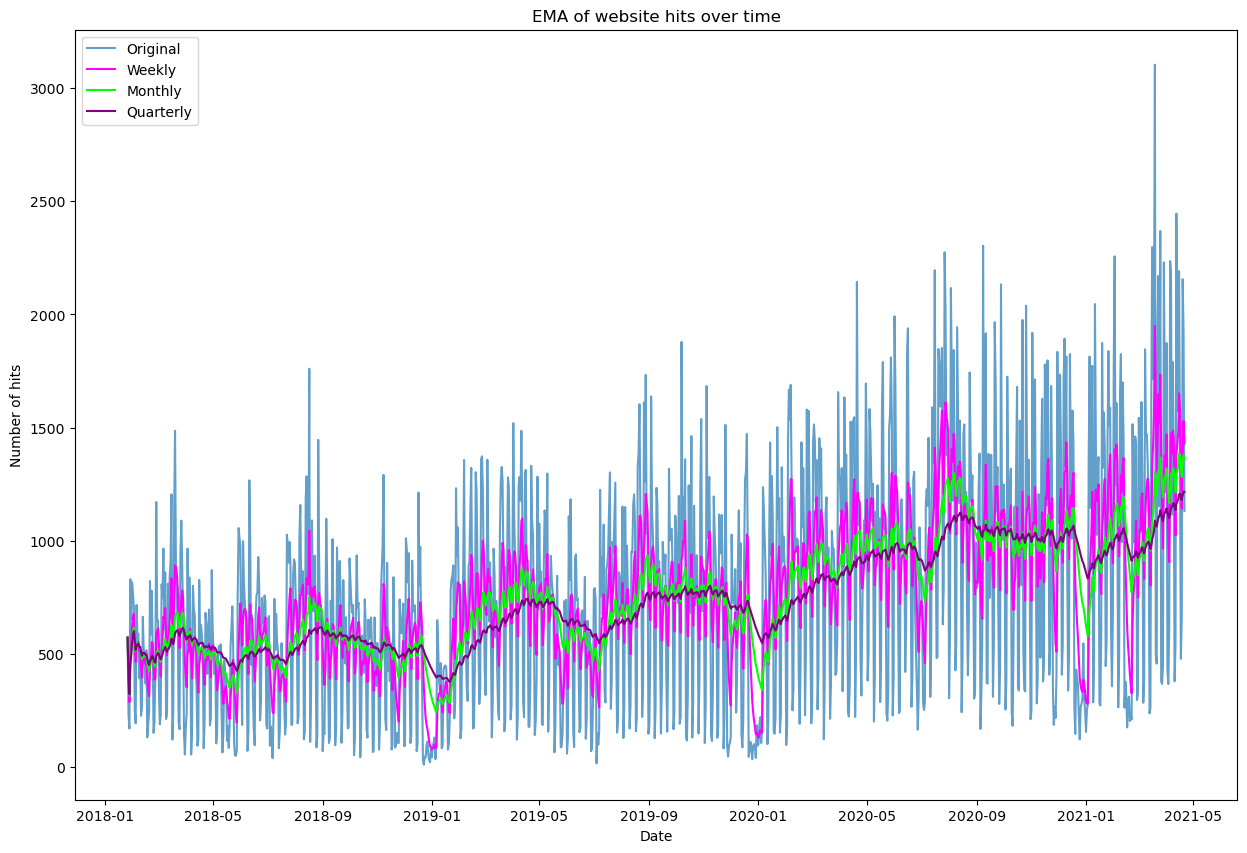

In [81]:
# plot the exponential moving averages (EMA) to see effects
# layering on top of each other using plt

plt.figure(figsize = (15, 10)) # (width, height)
plt.plot(daily_hits, label = 'Original', alpha = 0.7) 
                    # 'label' argument maps legend correctly to each series being plotted
plt.plot(weekly_avg, label = 'Weekly', c = 'magenta')
plt.plot(monthly_avg, label = 'Monthly', c = 'lime')
plt.plot(quarterly_avg, label = 'Quarterly', c = 'purple')

# labels and such for comprehension
plt.xlabel('Date')
plt.ylabel('Number of hits')
plt.title('EMA of website hits over time')
plt.legend()
plt.show()

### Bollinger Bands

Bollinger bands are used to indicate volatility in price over time, often used to detect 100-baggers in the stock market

Bollinger bands have three parts: lower band, upper band and midband (aka, the %b).  

The midband is the _exponential moving average_ for a defined period.  

The upper and lower bands are calculated using the following formula (cf boxplot, IQR) :  
Midband +/- Standard Deviation * K  

Look at how changing the value of K could change the number of anomalies detected.  
Upper / lower : Calculated to the midband.  Choosing a value of k * std dev then added or subtracted to or from midband.  


('They were designed by John Bollinger, a technical trader. The bands are used to generate signals for securities that are oversold or overbought. The bands are composed of different lines that are plotted on a chart, including the moving average, an upper band, and a lower band.' -Investopedia.com)

In [43]:
# remember the midband ! 
 # it has already been created

monthly_avg.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: path, dtype: float64

In [14]:
# compute exponential weighted standard deviation 

# aka, moving std dev that moves along with the midband and 
   # keeps the appropriate distance from upper & lower bands
    
    # This one band caputres the overall trend / direction in data
    # Use this to find upper & lower fences for wher an appropriate value should fall.
    # Are there cases when falling above / below the upper / lower bands ? Investigate.

monthly_std = daily_hits.ewm(span = 30).std()

monthly_std.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: path, dtype: float64

**Aka, a moving std dev that moves along with the midband and keeps the appropriate distance from upper & lower bands.**
    
This one band captures the overall trend / direction in data.  
Use this to find upper & lower fences for where an appropriate value should fall.  
Are there cases when falling above / below the upper / lower bands ? Investigate.  


In [15]:
# compute upper and lower bands

upper_band = monthly_avg + monthly_std * 1.5
lower_band = monthly_avg - monthly_std * 1.5

**k = 1.5 (k can be varied, depending on anomaly results)**

In [16]:
# create final df of hits (target) and mid-, upper, lower bands

final_df = pd.concat([daily_hits, monthly_avg, 
                      upper_band, lower_band], axis=1)

final_df.head()

,path,path,path,path
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,758.045779,32.554221
2018-01-28,170,315.139578,635.956785,-5.677629
2018-01-29,830,457.002386,931.704142,-17.699369
2018-01-30,652,501.369064,928.088655,74.649474


In [17]:
# rename columns

final_df.columns = ['hits', 'midband', 'upper_band', 'lower_band']

final_df.head()

# what to do about negative values ?

,hits,midband,upper_band,lower_band
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,758.045779,32.554221
2018-01-28,170,315.139578,635.956785,-5.677629
2018-01-29,830,457.002386,931.704142,-17.699369
2018-01-30,652,501.369064,928.088655,74.649474


Nothing comes from nothing, nothing ever could

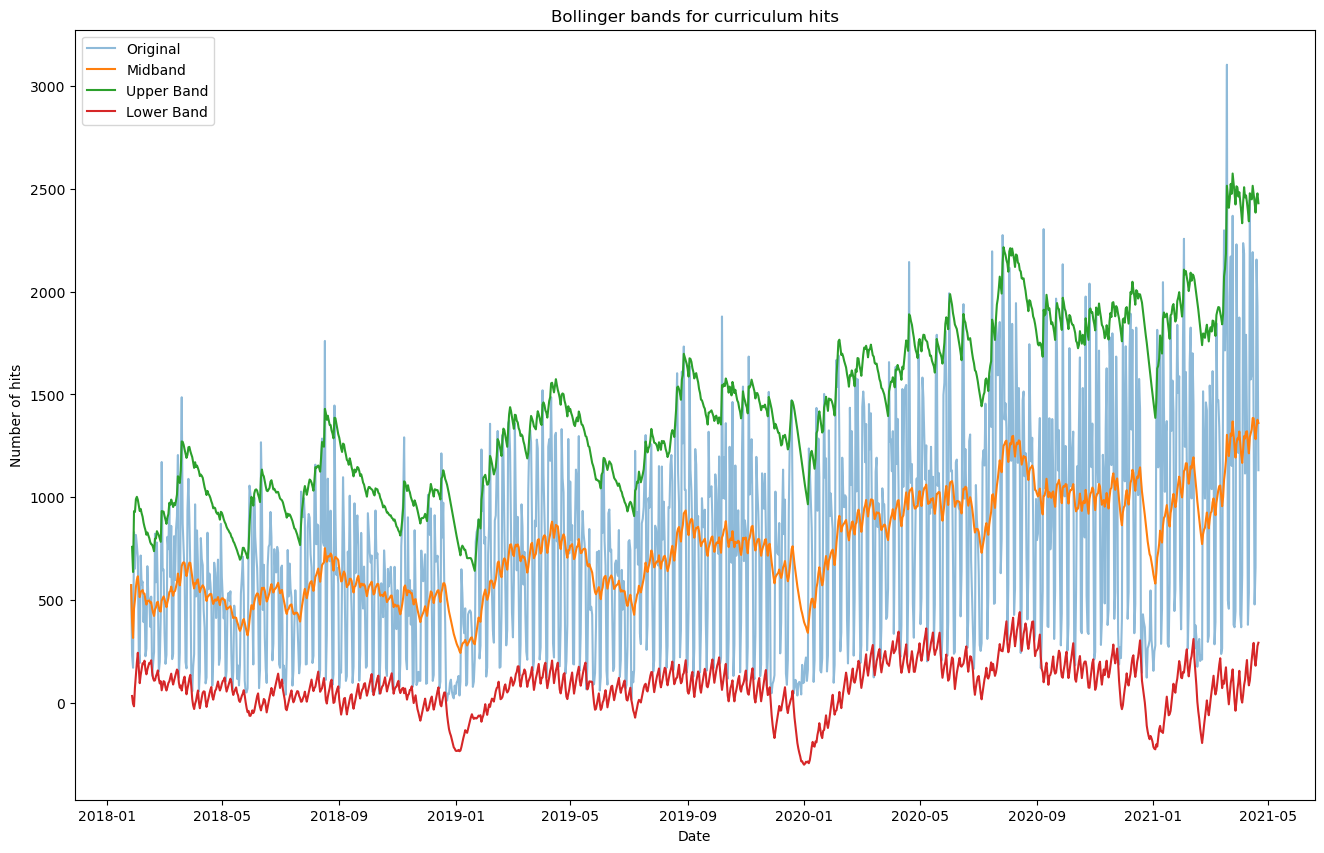

In [47]:
# plot the bands

plt.figure(figsize = (16, 10))

plt.plot(final_df['hits'], label = 'Original', alpha = 0.5)
plt.plot(final_df['midband'], label = 'Midband')
plt.plot(final_df['upper_band'], label = 'Upper Band')
plt.plot(final_df['lower_band'], label = 'Lower Band')

plt.xlabel('Date')
plt.ylabel('Number of hits')
plt.title('Bollinger bands for curriculum hits')
plt.legend()
plt.show()

### %b

The %b defines where a value lies relative to the bands.  A value that describes where the observation falls cf the bands that we've created. 

The formula for %b is : (last - Lower Band) / (Upper Band - Lower Band)

A value greater than 1 lies above the Upper Band, and a value less than 0 (negative value) lies below the Lower Band

In [48]:
# look at final dataframe again

final_df.head()

,hits,midband,upper_band,lower_band,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,758.045779,32.554221,0.272154
2018-01-28,170,315.139578,635.956785,-5.677629,0.273797
2018-01-29,830,457.002386,931.704142,-17.699369,0.892876
2018-01-30,652,501.369064,928.088655,74.649474,0.676499


In [50]:
# the formula to find %b with our df

(final_df['hits'] - final_df['lower_band']) / (final_df['upper_band'] - final_df['lower_band'])

date
2018-01-26         NaN
2018-01-27    0.272154
2018-01-28    0.273797
2018-01-29    0.892876
2018-01-30    0.676499
                ...   
2021-04-17    0.118394
2021-04-18    0.217310
2021-04-19    0.866464
2021-04-20    0.751201
2021-04-21    0.392491
Freq: D, Length: 1182, dtype: float64

In [53]:
# make new column for the %b that we calculated, add to df

final_df['pct_b'] = (final_df['hits'] - final_df['lower_band']) / (
                    (final_df['upper_band'] - final_df['lower_band']))
final_df.head()

,hits,midband,upper_band,lower_band,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,758.045779,32.554221,0.272154
2018-01-28,170,315.139578,635.956785,-5.677629,0.273797
2018-01-29,830,457.002386,931.704142,-17.699369,0.892876
2018-01-30,652,501.369064,928.088655,74.649474,0.676499


In [68]:
# check for anomalies on the high side
 
final_df[final_df['pct_b'] > 1].sort_values('pct_b', ascending = False).head()

,hits,midband,upper_band,lower_band,pct_b
date,,,,,
2018-02-27,1171,496.375166,932.523281,60.227052,1.273390
2018-08-17,1760,751.910516,1429.611841,74.209191,1.243756
2021-03-19,3104,1303.128816,2515.100114,91.157519,1.242951
2019-01-28,1232,447.643274,988.064736,-92.778188,1.225690
2019-10-07,1879,803.738383,1545.169017,62.307748,1.225126


**Largest high-side anomalies at top of list. Curious to know how many high-side anomalies there are.**

In [77]:
# finding how many high-side anomalies

final_df[final_df['pct_b'] > 1].value_counts().sum()

59

**There are 59 high-side anomalies.**

In [67]:
# low-side anomalies
 
final_df[final_df['pct_b'] < 0].sort_values('pct_b', ascending = True).head()

,hits,midband,upper_band,lower_band,pct_b
date,,,,,
2020-08-15,242,1205.934214,2098.302641,313.565786,-0.040099
2019-05-18,65,702.368176,1293.763070,110.973281,-0.038869
2020-09-05,168,985.144395,1746.086017,224.202772,-0.036930
2020-05-09,201,1005.779622,1755.608291,255.950954,-0.036642
2020-03-14,123,929.729604,1684.087680,175.371528,-0.034713


**Largest low-side anomalies at top of list.**

In [78]:
# finding how many low-side anomalies

final_df[final_df['pct_b'] < 0].value_counts().sum()

11

**There are 11 low-side anomalies.**